In [1]:
import numpy as np
import sys, os, glob
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

code_path = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Code/Task'

sys.path.append(code_path)
from misc_analysis import histogram, get_Q_true, analyse_recent_replays, analyse_other_replays, get_optimal_move, permutation_test, policy_improve, get_entropy, get_sorted_files
from misc import policy_choose, get_a_opp, compute_gain

In [2]:
root_folder = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay'

# Worlds & idcs
world1 = np.load(os.path.join(root_folder, 'Data/world1.npy'))
world2 = np.load(os.path.join(root_folder, 'Data/world2.npy'))
idcs1  = np.load(os.path.join(root_folder, 'Data/idcs1.npy'))
idcs2  = np.load(os.path.join(root_folder, 'Data/idcs2.npy'))

In [3]:
def convert_move(a):
    if np.isnan(a):
        pass
    elif a == 1:
        a = 2
    elif a == 2:
        a = 3
    elif a == 3:
        a = 0
    else:
        a = 1
    return a

def check_for_replays(z):

    move = z['move']
    s = move[0]
    a = move[1]
    
    check = False
    
    replay_backups  = np.atleast_2d(z['replay_backups'])
    for rid in range(replay_backups.shape[0]):
        this_replay = replay_backups[rid, :]
        sr = int(this_replay[0])
        ar = int(this_replay[1])

        if sr != -200 and ar != -200:
            if (sr == s) and (ar == a):
                check = True
    return check

def check_for_replays_2moves(z):
    
    move = z['move']
    s = move[0, 3]
    a = move[1, 1]
    
    check = False
    
    replay_backups  = np.atleast_2d(z['replay_backups'])
    for rid in range(replay_backups.shape[0]):
        this_replay = replay_backups[rid, :]
        sr = int(this_replay[0])
        ar = int(this_replay[1])

        pl = int(this_replay[4])
        if sr != -200 and ar != -200 and pl == 1:
            if (sr == s) and (ar == a):
                check = True
    return check

def check_for_any_replays(z):
    
    move = z['move']
    s = move[0]
    a = move[1]
    
    check = False
    
    replay_backups  = np.atleast_2d(z['replay_backups'])
    for rid in range(replay_backups.shape[0]):
        this_replay = replay_backups[rid, :]
        sr = int(this_replay[0])
        ar = int(this_replay[1])

        if sr != -200 and ar != -200:
            if (sr == s):
                check = True
    return check

### Check subjects' params before choosing

In [4]:
params_path     = os.path.join(root_folder, 'Data/new_new_fits')
subs_who_replay = np.load(os.path.join(root_folder, 'Data/tmp/Analysis', 'subs_who_replay.npy'))

In [5]:
for i in subs_who_replay:
    p = np.load(os.path.join(params_path, 'save_params_%u'%i, 'params.npy'))[:18]
    if len(str(i)) == 1:
        print('subject:  %u, phi^{MB}: %.2f, phi^{MF}: %.2f, xi: %.4E'%(i, p[8], p[9], p[15]))
    else:
        print('subject: %u, phi^{MB}: %.2f, phi^{MF}: %.2f, xi: %.4E'%(i, p[8], p[9], p[15]))

subject:  0, phi^{MB}: 0.99, phi^{MF}: 0.80, xi: 6.1615E-04
subject:  2, phi^{MB}: 1.00, phi^{MF}: 0.93, xi: 4.6660E-05
subject:  3, phi^{MB}: 1.00, phi^{MF}: 0.57, xi: 3.8372E-03
subject:  6, phi^{MB}: 0.45, phi^{MF}: 0.91, xi: 1.3270E-04
subject:  8, phi^{MB}: 1.00, phi^{MF}: 0.99, xi: 2.8122E-03
subject:  9, phi^{MB}: 0.79, phi^{MF}: 0.54, xi: 4.7780E-04
subject: 11, phi^{MB}: 0.94, phi^{MF}: 0.69, xi: 1.1753E-02
subject: 12, phi^{MB}: 0.15, phi^{MF}: 0.96, xi: 1.8635E-04
subject: 14, phi^{MB}: 0.95, phi^{MF}: 0.93, xi: 1.5382E-03
subject: 15, phi^{MB}: 0.19, phi^{MF}: 0.94, xi: 2.3405E-03
subject: 16, phi^{MB}: 0.95, phi^{MF}: 0.58, xi: 4.6570E-05
subject: 19, phi^{MB}: 1.00, phi^{MF}: 0.66, xi: 2.1507E-04
subject: 21, phi^{MB}: 1.00, phi^{MF}: 0.79, xi: 6.5930E-05
subject: 27, phi^{MB}: 0.12, phi^{MF}: 0.92, xi: 1.6069E-04
subject: 28, phi^{MB}: 0.02, phi^{MF}: 0.87, xi: 3.9813E-03
subject: 29, phi^{MB}: 0.87, phi^{MF}: 0.36, xi: 5.4702E-03
subject: 32, phi^{MB}: 1.00, phi^{MF}: 0

### Get the moves to look at

In [197]:
task_folder = os.path.join(root_folder, 'Data/tmp/')

sub      = 2
fig_name = 'supp4'

sub_task_folder = os.path.join(task_folder, str(sub))

for i in range(5):
    if i == 0:
        this_range = 6
    else:
        this_range = 7
    
    if i in [0, 1]:
        Q1_true, Q2_true = get_Q_true(world1, idcs1)
    elif i in [2, 3]:
        Q1_true, Q2_true = get_Q_true(world2, idcs1)
    else:
        Q1_true, Q2_true = get_Q_true(world2, idcs2)
                
    for j in range(this_range):
        # Prepare to load files
        epoch_folder = os.path.join(sub_task_folder, str(i), str(j))
        all_files_sorted = get_sorted_files(epoch_folder)

        for f in range(len(all_files_sorted)):
            
            this_file = all_files_sorted[f]
            data      = np.load(this_file, allow_pickle=True)
            move      = data['move']
            if len(move) == 2:
                pass
            else:
                s = move[0]
                a = move[1]
                if a not in get_optimal_move(s, Q2_true):
                    if check_for_replays(data):
#                     if check_for_any_replays(data):
                        print('Block: %u, folder: %u, trial: %u'%(i,j,f), move)

Block: 0, folder: 2, trial: 0 [1 0 2 5]
Block: 2, folder: 3, trial: 3 [3 1 2 7]
Block: 2, folder: 5, trial: 3 [7 2 8 6]


### Choose the move

In [214]:
# Objective benefit
# Same move as human
# Sub 19
# block    = 2
# epoch    = 5
# file     = 3

# Sub 3
# block    = 4
# epoch    = 5
# file     = 5

# Sub 16
# block    = 2
# epoch    = 4
# file     = 0

# Subjective benefit
# Same move as human
# Sub 3
block = 0
epoch = 2
file  = 0

if block >= 2:
    world = world2
else:
    world = world1

if block == 4:
    idcs = idcs2
else:
    idcs = idcs1

data  = os.path.join(task_folder, '%u/%u/%u/move%u.npz'%(sub, block, epoch, file))

if file == 0:
    if epoch == 0:
        specs = (sub, block-1, 5, 11)
    else:
        specs = (sub, block, epoch-1, 5)
else:
    specs = (sub, block, epoch, file-1)
    
data_pre = os.path.join(task_folder, '%u/%u/%u/move%u.npz'%specs)
params   = os.path.join(root_folder, 'Data/new_new_fits/save_params_%u/params.npy'%sub)
p        = np.load(params)
z        = np.load(data, allow_pickle=True)

if len(z['move']) == 2:
    num_moves = 2
else:
    num_moves = 1

In [215]:
print(z['move'])

[1 0 2 5]


In [216]:
replays = np.zeros(32)
replay_backups  = z['replay_backups']
for rid in range(replay_backups.shape[0]):
    this_replay = replay_backups[rid, :]
    sr = int(this_replay[0])
    ar = int(this_replay[1])
    rr = this_replay[2]
    s1r = this_replay[3]
    
    if num_moves == 2:
        pl = int(this_replay[4])
        if sr != -200 and ar != -200 and pl == 1:
            if len(str(rid)) == 2:
                print(rid, ':', [sr, ar, np.round(rr, 4), s1r])
            else:
                print(rid, ' :', [sr, ar, np.round(rr, 4), s1r])
            replays[sr*4 +ar] += 1
    else:
        if sr != -200 and ar != -200:
            if len(str(rid)) == 2:
                print(rid, ':', [sr, ar, np.round(rr, 4), s1r])
            else:
                print(rid, ' :', [sr, ar, np.round(rr, 4), s1r])
            replays[sr*4 +ar] += 1

1  : [1, 0, 2.6043, 5.0]
2  : [1, 0, 2.6043, 5.0]
3  : [1, 1, 2.2019, 5.0]
4  : [1, 0, 2.6043, 5.0]
5  : [1, 1, 2.2019, 5.0]
6  : [1, 0, 2.6043, 5.0]
7  : [1, 1, 2.2019, 5.0]
8  : [1, 0, 2.6043, 5.0]
9  : [5, 0, 8.6653, 1.0]
10 : [1, 1, 2.2019, 5.0]
11 : [1, 0, 2.6043, 5.0]
12 : [5, 0, 8.6653, 1.0]
13 : [1, 0, 2.6043, 5.0]
14 : [1, 1, 2.2019, 5.0]
15 : [5, 0, 8.6653, 1.0]
16 : [1, 2, 0.3028, 0.0]
17 : [1, 0, 2.6043, 5.0]
18 : [1, 1, 2.2019, 5.0]
19 : [5, 0, 8.6653, 1.0]
20 : [1, 0, 2.6043, 5.0]
21 : [1, 1, 2.2019, 5.0]
22 : [5, 0, 8.6653, 1.0]
23 : [6, 0, 5.2857, 0.0]
24 : [6, 1, 5.2857, 0.0]
25 : [0, 3, 8.76, 1.0]
26 : [1, 2, 0.3028, 0.0]
27 : [1, 0, 2.6043, 5.0]
28 : [1, 1, 2.2019, 5.0]


### Replays after that move

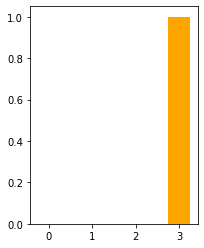

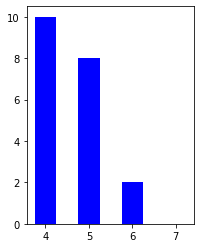

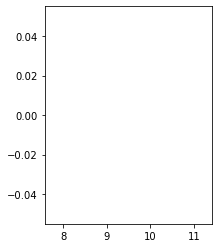

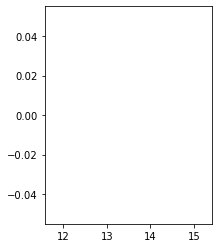

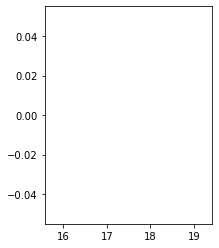

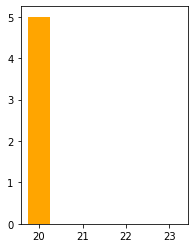

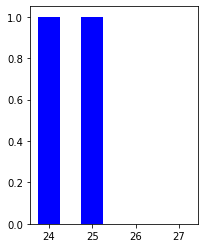

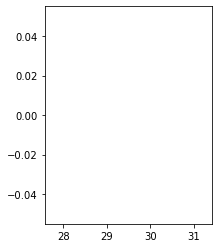

In [217]:
_, Q2_true = get_Q_true(world, idcs)
for s in range(8):
    fig = plt.figure(figsize=(3, 4))
    for a in range(4):
        if a in get_optimal_move(s, Q2_true):
            plt.bar(s*4+a, replays[s*4+a], facecolor='orange', align='center', width=0.5)
        else:
            plt.bar(s*4+a, replays[s*4+a], facecolor='b', align='center', width=0.5)
    plt.savefig(os.path.join(root_folder, 'new_figures_data/%s/d/replays_%u_%u.svg'%(fig_name, sub, s)), transparent=True, format='svg')
np.save(os.path.join(root_folder, 'new_figures_data/%s/d/replays_data.npy'%fig_name), replays)

### Objective policy change due to those replays

State 0, opt: 0.00023
State 1, opt: 0.30195
State 2, opt: 0.00000
State 3, opt: 0.00000
State 4, opt: 0.00000
State 5, opt: 0.00024
State 6, opt: 0.00316
State 7, opt: 0.00000


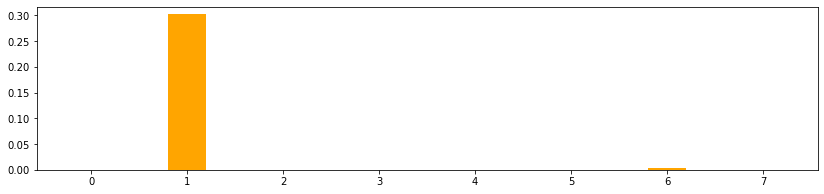

In [218]:
if num_moves == 2:
    Q = z['Q2_history']
else:
    Q = z['Q_history']
Q_before = Q[0].reshape(8, -1)
Q_after  = Q[-1].reshape(8, -1)

_, Q2_true = get_Q_true(world, idcs)

beta = p[0]
a    = p[10]
b    = p[11]
d    = -(a+b)
biases = np.array([a, b, 0, d])

opt_save = []
fig = plt.figure(figsize=(14, 3))
for s in range(8):
    opt = policy_improve(Q_before[s, :], Q_after[s, :], Q2_true, s, beta, biases, world, idcs, mode='value', benefit='objective')
    print('State %u, opt: %.5f'%(s, opt))
    plt.bar(s, opt, facecolor='orange', width = 0.4)
    opt_save += [opt]
plt.savefig(os.path.join(root_folder, 'new_figures_data/%s/e/'%fig_name, '%u_policy_objective.svg'%sub), transparent=True, format='svg')
np.save(os.path.join(root_folder, 'new_figures_data/%s/e/policy_data_objective.npy'%fig_name), opt_save)


### Action entropy values 

0 0 alpha: 0
0 1 alpha: 15.0
0 2 alpha: 0
0 3 alpha: 83.0
1 0 alpha: 49.0
1 1 alpha: 78.0
1 2 alpha: 82.0
1 3 alpha: 88.0
2 0 alpha: 0
2 1 alpha: 0
2 2 alpha: 88.0
2 3 alpha: 51.0
3 0 alpha: 80.0
3 1 alpha: 0
3 2 alpha: 48.0
3 3 alpha: 0
4 0 alpha: 17.0
4 1 alpha: 0
4 2 alpha: 84.0
4 3 alpha: 17.0
5 0 alpha: 80.0
5 1 alpha: 48.0
5 2 alpha: 15.0
5 3 alpha: 15.0
6 0 alpha: 0
6 1 alpha: 0
6 2 alpha: 17.0
6 3 alpha: 17.0
7 0 alpha: 0
7 1 alpha: 78.0
7 2 alpha: 15.0
7 3 alpha: 85.0


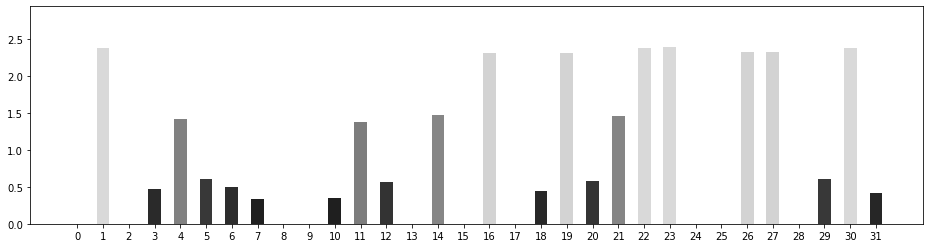

In [203]:
fig = plt.figure(figsize=(16, 4))
max_ent = np.log2(7)

opt    = []
subopt = []

T = z['T']
for s in range(8):
    for a in range(4):
        ent = get_entropy(T, s, a)
        
        if a in get_optimal_move(s, Q2_true):
            opt += [ent]
        else:
            subopt += [ent]
        
        alp = 1-(ent/max_ent)
        if alp <= 0:
            alp = 0
        plt.bar(s*4+a, ent, facecolor='k', width=0.5, alpha = alp)
        print(s, a, 'alpha:', np.round(alp*100))
plt.savefig(os.path.join(root_folder, 'new_figures_data/%s/b'%fig_name, '%u_entropy.svg'%sub), transparent=True, format='svg')
np.save(os.path.join(root_folder, 'new_figures_data/%s/b/entropy_data.npy'%fig_name), opt_save)
plt.xticks(range(32), range(32));

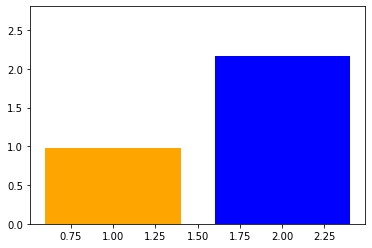

In [204]:
plt.bar([1], np.mean(opt), facecolor='orange')
plt.bar([2], np.mean(subopt), facecolor='b')

plt.ylim(0, np.log2(7))
plt.savefig(os.path.join(root_folder, 'new_figures_data/%s/b'%fig_name, '%u_entropy_av.svg'%sub), transparent=True, format='svg')
np.savez(os.path.join(root_folder, 'new_figures_data/%s/b/entropy_av_data.npz'%fig_name), opt=opt, subopt=subopt)

### Agent's state of knowledge

In [205]:
_, Q2_true = get_Q_true(world, idcs)

move  = z['move']
alpha = p[3]
T     = z['T']
tau   = p[9]

if num_moves == 2:
    Q        = z['Q2_history'][0].reshape(8, 4)
    rew_hist = z['rew_history'][1]
    s = int(move[0][3])
    a = int(move[1][1])
    r = move[1][2]
    
    av_rew   = np.mean(rew_hist)

    Q_pre    = (Q  - av_rew*(1-tau))/tau

    Q_before = (Q_pre[s, a] - alpha*r)/(1-alpha)

else:
    Q        = z['Q_history'][0].reshape(8, 4)
    rew_hist = z['rew_history']
    s = int(move[0])
    a = int(move[1])
    r = move[2]
    
#     av_rew   = np.mean(rew_hist)
    
#     Q_pre    = (Q  - av_rew*(1-tau))/tau
    Q_pre    = Q.copy()
    Q_before = (Q_pre[s, a] - alpha*r)/(1-alpha)

State 1, action 0
Before on-line: 6.005093794092967
After on-line: 3.2261578630240444
Q^{MB}: 2.6042675886084763


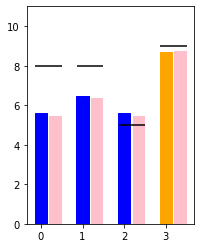

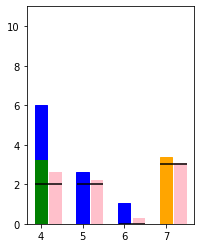

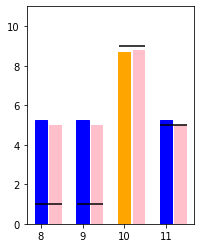

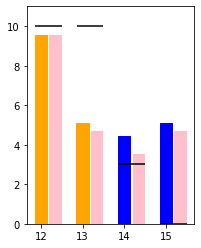

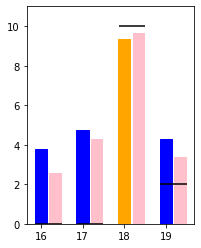

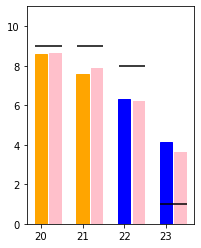

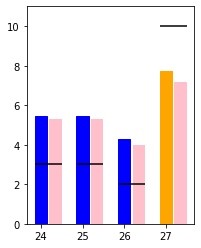

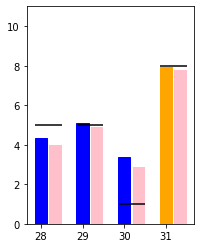

In [206]:
for si in range(8):
    fig = plt.figure(figsize=(3, 4))
    a_opt = get_optimal_move(si, Q2_true)
    q_mb = []
    for ai in range(4):
        this_action_probas = T[si, ai, :]
        r = np.sum(world.ravel()*this_action_probas)
        q_mb += [r]
        if ai in a_opt:
            plt.bar(si*4+ai, Q_pre[si, ai], facecolor='orange', edgecolor='orange', align='center',width=0.3)
        else:
            if si == s and ai == a:
                if Q_before < Q_pre[si, ai]:
                    plt.bar(si*4+ai, Q_pre[si, ai], facecolor='green', edgecolor='green', align='center',width=0.3)
                    plt.bar(si*4+ai, Q_before, facecolor='b', edgecolor='b', align='center',width=0.3)
                else:
                    plt.bar(si*4+ai, Q_before, facecolor='b', edgecolor='b', align='center',width=0.3)
                    plt.bar(si*4+ai, Q_pre[si, ai], facecolor='green', edgecolor='green', align='center',width=0.3)
                print('State %u, action %u'%(s, a))
                print('Before on-line:', Q_before)
                print('After on-line:', Q_pre[si, ai])
                print('Q^{MB}:', r)
            else:
                plt.bar(si*4+ai, Q_pre[si, ai], facecolor='b', edgecolor='b', align='center',width=0.3)
        plt.bar(si*4+ai+0.35, r, facecolor='pink', width=0.3)
        plt.hlines(Q2_true[si, ai], si*4+ai-0.13, si*4+ai+0.5, color='k')
    plt.ylim(0, 11)
    plt.savefig(os.path.join(root_folder, 'new_figures_data/%s/c'%fig_name, 'Q_before_%u.svg'%si), transparent=True, format='svg')
    if si != s:
        np.savez(os.path.join(root_folder, 'new_figures_data/%s/c'%fig_name, 'Q_%u.npz'%si), q_mf=Q_pre[si, :], q_mb=q_mb)
    else:
        np.savez(os.path.join(root_folder, 'new_figures_data/%s/c'%fig_name, 'Q_%u.npz'%si), q_mf=Q_pre[si, :], q_mf_before=Q_before, q_mb=q_mb)


### Replays / entropy

In [219]:
sub_task_folder = os.path.join(root_folder, 'Data/tmp/%u'%sub)
opt, subopt, H_opt_single, H_subopt_single, H_opt_paired, H_subopt_paired = analyse_recent_replays(sub_task_folder)

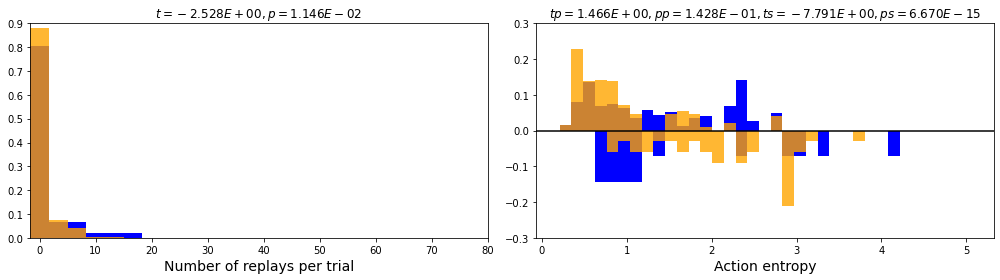

In [220]:
plt.figure(figsize=(14, 4))

# Replays
plt.subplot(1, 2, 1)
max_bins = 80
bins = np.linspace(0, max_bins, 25)
subopt_h, subopt_b, subopt_w = histogram(subopt, bins)
plt.bar(subopt_b, subopt_h, width=subopt_w, facecolor='b')
opt_h, opt_b, subopt_w = histogram(opt, bins)
plt.bar(opt_b, opt_h, width=subopt_w, facecolor='orange', alpha=0.8)
plt.xlabel('Number of replays per trial', fontsize=14)
plt.xlim(0-subopt_w/2, max_bins)
# plt.xticks(np.arange(0, 40, 5), np.arange(0, 40, 5), fontsize=10)
t, p = scipy.stats.ranksums(opt, subopt)
# t, p = permutation_test(opt, subopt, 100000)
plt.title(r'$t=%.3E, p=%.3E$'%(t, p));
plt.ylim(0, 0.9)

# Single entropy
plt.subplot(1, 2, 2)
bins=np.linspace(0, np.log2(7)+np.log2(6), 40)
H_subopt_h, H_subopt_b, H_subopt_w = histogram(H_subopt_single, bins)
plt.bar(H_subopt_b, H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_single, bins)
plt.bar(H_opt_b, H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)
plt.xlim(0-H_subopt_w/2, np.log2(7)+np.log2(6)-H_subopt_w/2)

# Paired entropy
H_subopt_h, H_subopt_b, _ = histogram(H_subopt_paired, bins)
plt.bar(H_subopt_b, -H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_paired, bins)
plt.bar(H_opt_b, -H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)
# plt.axvline(np.log2(7)+H_subopt_w/4)

plt.ylim(-0.3, 0.3)
plt.axhline(0, c='k')
plt.xlabel('Action entropy', fontsize=14)
ts, ps = scipy.stats.ranksums(H_opt_single, H_subopt_single)
tp, pp = scipy.stats.ranksums(H_opt_paired, H_subopt_paired)
# ts, ps = permutation_test(H_opt_single, H_subopt_single, 100000)
# tp, pp = permutation_test(H_opt_paired, H_subopt_paired, 100000)
plt.title(r'$tp=%.3E, pp=%.3E, ts=%.3E, ps=%.3E$'%(tp, pp, ts, ps));
plt.tight_layout()
# 
plt.savefig(os.path.join(root_folder, 'new_figures_data/%s/g/recent_replays.svg'%fig_name), format='svg', transparent=True)

In [221]:
H_opt_paired_exp    = H_opt_paired.copy()
H_subopt_paired_exp = H_subopt_paired.copy()
H_opt_single_exp    = H_opt_single.copy()
H_subopt_single_exp = H_subopt_single.copy()

opt_all_exp    = opt.copy()
subopt_all_exp = subopt.copy()

In [222]:
sub_task_folder = os.path.join(root_folder, 'Data/tmp/%u'%sub)
opt, subopt, H_opt_single, H_subopt_single, H_opt_paired, H_subopt_paired = analyse_other_replays(sub_task_folder)

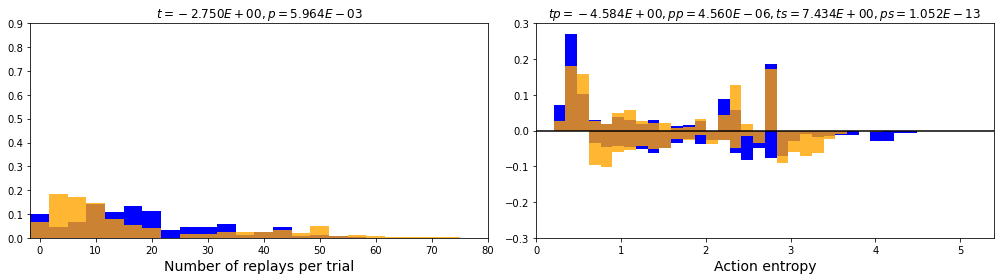

In [223]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
max_bins = 80
bins = np.linspace(0, max_bins, 25)
subopt_h, subopt_b, subopt_w = histogram(subopt, bins)
plt.bar(subopt_b, subopt_h, width=subopt_w, facecolor='b')
opt_h, opt_b, subopt_w = histogram(opt, bins)
plt.bar(opt_b, opt_h, width=subopt_w, facecolor='orange', alpha=0.8)
plt.xlabel('Number of replays per trial', fontsize=14)
plt.xlim(0-subopt_w/2, max_bins)
# plt.xticks(np.arange(0, 40, 5), np.arange(0, 40, 5), fontsize=10)
t, p = scipy.stats.ranksums(opt, subopt)
# t, p = permutation_test(opt, subopt, 100000)
plt.title(r'$t=%.3E, p=%.3E$'%(t, p));
plt.ylim(0, 0.9)

# Single entropy
plt.subplot(1, 2, 2)
bins=np.linspace(0, np.log2(7)+np.log2(6), 40)
H_subopt_h, H_subopt_b, H_subopt_w = histogram(H_subopt_single, bins)
plt.bar(H_subopt_b, H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_single, bins)
plt.bar(H_opt_b, H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)
plt.xlim(0-H_subopt_w/2, np.log2(7)+np.log2(6)+H_subopt_w/2)

# Paired entropy
H_subopt_h, H_subopt_b, _ = histogram(H_subopt_paired, bins)
plt.bar(H_subopt_b, -H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_paired, bins)
plt.bar(H_opt_b, -H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)

plt.ylim(-0.3, 0.3)
plt.axhline(0, c='k')
plt.xlabel('Action entropy', fontsize=14)
ts, ps = scipy.stats.ranksums(H_opt_single, H_subopt_single)
tp, pp = scipy.stats.ranksums(H_opt_paired, H_subopt_paired)
plt.title(r'$tp=%.3E, pp=%.3E, ts=%.3E, ps=%.3E$'%(tp, pp, ts, ps));
plt.tight_layout()

plt.xlim([0, np.log2(7)+np.log2(6)])

plt.savefig(os.path.join(root_folder, 'new_figures_data/%s/h/other_replays.svg'%fig_name), format='svg', transparent=True)

In [224]:
with open(os.path.join(root_folder, 'new_figures_data/%s'%fig_name, 'replay_stats.txt'), 'w') as f:
    t, p_ent_opt = scipy.stats.ranksums(H_opt_paired_exp, H_opt_paired)
    f.write('H_opt_paired_exp vs H_opt_paired:       t = %.3E, p = %.3E\n'%(t, p_ent_opt))
    t, p_ent_opt = scipy.stats.ranksums(H_opt_single_exp, H_opt_single)
    f.write('H_opt_single_exp vs H_opt_single:       t = %.3E, p = %.3E\n'%(t, p_ent_opt))
    t, p_ent_subopt = scipy.stats.ranksums(H_subopt_paired_exp, H_subopt_paired)
    f.write('H_subopt_paired_exp vs H_subopt_paired: t = %.3E, p = %.3E\n'%(t, p_ent_subopt))
    t, p_ent_subopt = scipy.stats.ranksums(H_subopt_single_exp, H_subopt_single)
    f.write('H_subopt_single_exp vs H_subopt_single: t = %.3E, p = %.3E\n'%(t, p_ent_subopt))

    t, p_subopt = scipy.stats.ranksums(subopt_all_exp, subopt)
    f.write('subopt_all_exp vs subopt_all: t = %.3E, p = %.3E\n'%(t, p_subopt))

    t, p_opt = scipy.stats.ranksums(opt_all_exp, opt)
    f.write('opt_all_exp vs opt_all:       t = %.3E, p = %.3E\n'%(t, p_opt))